In [1]:
import sys
sys.path.append("../")
from libraries.dataManipulation import *
from libraries.gridManipulation import *
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import random
import warnings
warnings.filterwarnings(action='ignore')
import time

In [2]:
from sociophysicsDataHandler import SociophysicsDataHandler

In [3]:
def convert_to_unixtimestamp(datetime_utc):
    return (datetime_utc - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

In [4]:
#Check for train
#TODO
def check_train(timestamp):
    train_present = False

In [5]:
#Spawn people
def spawn_people(timestamp):
    global current_ID, simulation_tuple
    if timestamp in people_in_dictionary_off:
        spawn_zones = people_in_dictionary_off[timestamp]
        for zone in spawn_zones:
            offboarding_people_locs[current_ID] = zone
            simulation_tuple.extend([[current_ID,True,False,timestamp,zone]])
            current_ID += 1
    
    if timestamp in people_in_dictionary_on:
        spawn_zones = people_in_dictionary_on[timestamp]
        for zone in spawn_zones:
            onboarding_people_locs[current_ID] = zone
            simulation_tuple.extend([[current_ID,False,True,timestamp,zone]])
            current_ID += 1

In [6]:
#Determine the density based on the locations of people
def calculate_density():
    locs = {**onboarding_people_locs,**offboarding_people_locs}
    
    #Create empty density dictionary
    density = {} #Dictionary with zone IDs as keys and density as values
    #Set all densities to 0
    for i in range(n_zones+void_zones):
        density[i] = 0
    
    #Cycle through all the people in the locs dictionary
    for i in locs.keys():
        density[locs[i]] += 1
        
    return density

In [7]:
#Get a new zone for a person a markov matrix and a randomly generated number
def get_new_zone(current_zone, markov_matrix):

    #Get the probabilities for the zone and apply the randomness
    probabilities = markov_matrix.iloc[current_zone].to_numpy()
    probabilities = adjust_probability(probabilities, density)
    i = 0 #Iterator to keep track of which column/movement must be selected
    if (sum(probabilities) == 0):
        rand  = 0
    else:
        rand = random.random() * sum(probabilities)
        
    while rand > probabilities[i]:
        rand -= probabilities[i]
        i += 1

    #Get the new zone based on the movement (column of markov matrix) that is selected
    return i
    

In [8]:
#Function to relate density to probability adjustment
def density_probability(density):
    #Example function
    return (-density) / 10000

In [9]:
#Adjust the probabilities of moving between zones according to density in neighbouring zones
#The input probabilities is an 1D array for several zones
def adjust_probability(probabilities, density):
    probabilities = probabilities + density_probability( np.array(list(density.values())) )
    probabilities[probabilities<0] = 0
    return probabilities

In [10]:
#Change the position of people according to the corresponding markov matrix
def move():
    global simulation_tuple
    
    #Loop through offboarders with markov matrix adjusted for density
    markov_matrix = markov_matrix_offboarding
    
    for offboarder_ID, current_zone in offboarding_people_locs.items():
        
        new_zone = get_new_zone(current_zone, markov_matrix)
        
        offboarding_people_locs[offboarder_ID] = new_zone
        simulation_tuple.extend([[offboarder_ID,True,False,time,new_zone]])
    
    #Loop through onboarders with markov matrix adjusted for density and whether there is a train
    if train_present:
        markov_matrix = markov_matrix_onboarding_train
    else:
        markov_matrix = markov_matrix_onboarding_no_train
        
    for onboarder_ID, current_zone in onboarding_people_locs.items():
        
        new_zone = get_new_zone(current_zone, markov_matrix)

        onboarding_people_locs[onboarder_ID] = new_zone
        simulation_tuple.extend([[onboarder_ID,False,True,time,new_zone]])
         

In [60]:
%%time

#Initialize variables
start_date_time = pd.to_datetime('2020-04-20T12:00:00') #Starting time of simulation
time = convert_to_unixtimestamp(start_date_time)
sim_duration = 3600 #How long the simulation lasts in seconds

train_present = False

#Number of zones
zone_rows = 4
zone_columns = 18
n_zones = zone_rows * zone_columns
void_zones = 0 #Number of zones that people can disappear to

#Variables that have to be determined in different steps
markov_matrix_offboarding = pd.read_csv('test_markov_matrix.csv', header=None)
markov_matrix_onboarding_no_train =  pd.read_csv('test_markov_matrix.csv', header=None)
markov_matrix_onboarding_train =  pd.read_csv('test_markov_matrix.csv',header=None)
density_influence_table = None
people_in_dictionary_off = {time:range(60)}
people_in_dictionary_on = {time:range(60)}

#Information about people
current_ID = 1000 #People will also have an ID in the simulation, only a different one
offboarding_people_locs = {} #Dictionary with person IDs as keys and zone IDs as values
onboarding_people_locs = {} #Dictionary with person IDs as keys and zone IDs as values
density = {} #Dictionary with zone IDs as keys and density as values
#Set all densities to 0
for i in range(n_zones + void_zones):
    density[i] = 0
    
#Create dataframe to store the data over time
simulation_tuple = ([[0,False,False,0,0]])

# SIMULATE 

#Start looping
for i in range(sim_duration):
    
    check_train(time)
    
    move()
    
    spawn_people(time)
    
    density = calculate_density()
    
    time += 1

simulation_df = pd.DataFrame(list(simulation_tuple), columns = ['ID','Offboarding','Onboarding','Time','Zone'])
simulation_df = simulation_df.drop(0)
simulation_df['x_pos'] = simulation_df['Zone'].divide(zone_rows).apply(np.floor)
simulation_df['y_pos'] = (simulation_df['Zone']).mod(zone_rows)
simulation_df.head()

Wall time: 39.6 s


,ID,Offboarding,Onboarding,Time,Zone,x_pos,y_pos
1,1000,True,False,1587384000,0,0.0,0
2,1001,True,False,1587384000,1,0.0,1
3,1002,True,False,1587384000,2,0.0,2
4,1003,True,False,1587384000,3,0.0,3
5,1004,True,False,1587384000,4,1.0,0


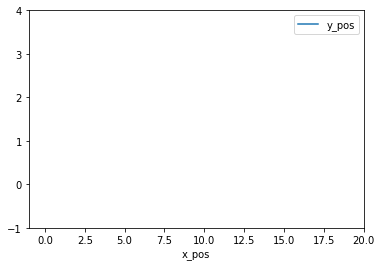

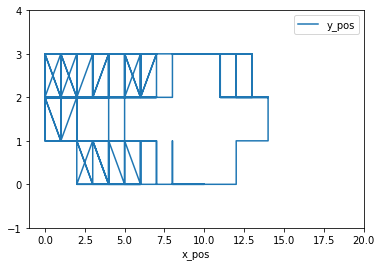

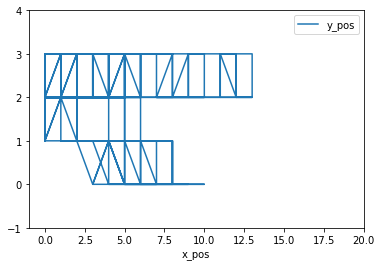

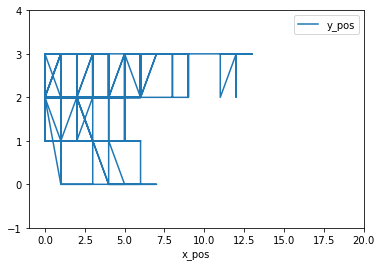

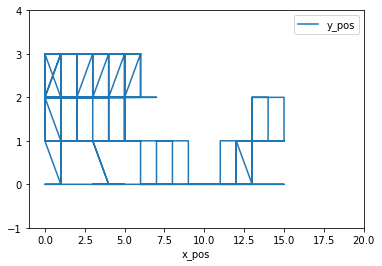

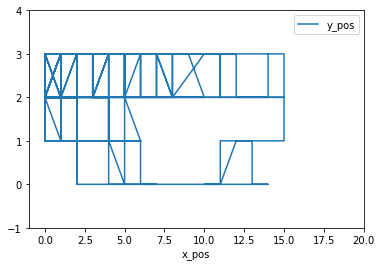

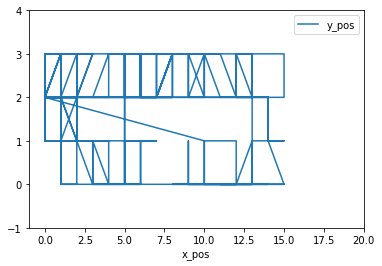

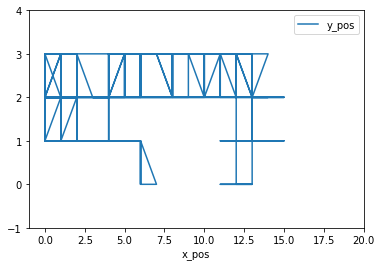

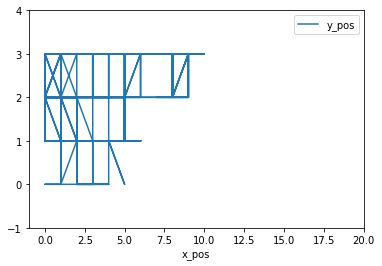

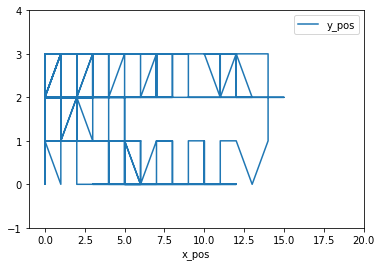

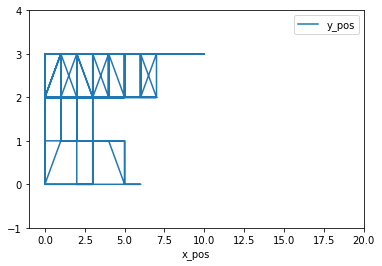

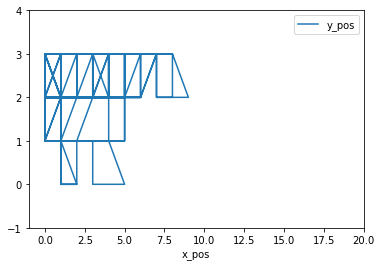

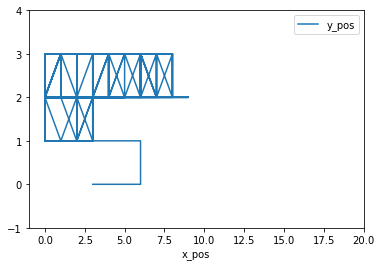

In [12]:
ax = simulation_df.groupby('ID').plot('x_pos','y_pos', xlim = [-1, 20], ylim = [-1,4]);

In [52]:
array = np.empty([0,1])
array = np.append(array, np.array([11, 21, 31, 41]), axis=0)
array = np.append(array, np.array([11, 21, 31, 41]), axis=0)
array

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)